In [1]:
# Import the dependencies.
# Mandatory
from sqlalchemy import create_engine, text, inspect

# ORM imports - for classes
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, func, case
from sqlalchemy.orm import Session
from sqlalchemy.ext.declarative import declarative_base

#data science
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Other imports
import datetime as dt

# Import DB credentials
import config as cfg

## Connecting to Postgres

In [2]:
# Setup the SQL connection variables
SQL_USERNAME = cfg.SQL_USERNAME
SQL_PASSWORD = cfg.SQL_PASSWORD
SQL_IP = cfg.SQL_IP
SQL_PORT = cfg.SQL_PORT
DATABASE = cfg.DATABASE

In [3]:
# Connect to PostgreSQL server
connection_string = f'postgresql+psycopg2://{SQL_USERNAME}:{SQL_PASSWORD}@{SQL_IP}:{SQL_PORT}/{DATABASE}'
engine = create_engine(connection_string)

In [4]:
# explore and understand the data

# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within each table and its types
for table in tables:
    print(table)
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])
        
    print()

contact
contact_id INTEGER
first_name VARCHAR(30)
last_name VARCHAR(30)
email VARCHAR(50)
last_update TIMESTAMP

campaign
funding_id INTEGER
contact_id INTEGER
company_name VARCHAR(50)
description VARCHAR(75)
goal NUMERIC
pledged NUMERIC
outcome VARCHAR(10)
backers_count INTEGER
country VARCHAR(2)
currency VARCHAR(3)
launched_date TIMESTAMP
end_date TIMESTAMP
staff_pick BOOLEAN
spotlight BOOLEAN
category_id VARCHAR(10)
subcategory_id VARCHAR(12)
last_update TIMESTAMP

category
category_id VARCHAR(10)
category VARCHAR(50)
last_update TIMESTAMP

subcategory
subcategory_id VARCHAR(12)
subcategory VARCHAR(50)
last_update TIMESTAMP



In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

# Print all of the classes mapped to the Base
print(list(Base.classes))

[<class 'sqlalchemy.ext.automap.campaign'>, <class 'sqlalchemy.ext.automap.subcategory'>, <class 'sqlalchemy.ext.automap.contact'>, <class 'sqlalchemy.ext.automap.category'>]


In [6]:
# THIS IS ORM STUFF TO DEFINE CLASSES

# Assign the classes to variables
# documentation from https://docs.sqlalchemy.org/en/14/orm/extensions/automap.html - Reference Basic Use
Contact = Base.classes.contact
Campaign = Base.classes.campaign
Category = Base.classes.category
Subcategory = Base.classes.subcategory

# Create a session
session = Session(engine)

## Single DataFrame combining all 4 tables (contacts, campaigns, categories and subcategories)

#### Method 1: SQL Statement

In [7]:
query = """
		SELECT
			cont.first_name,
			cont.last_name,
			cont.email,
			camp.company_name,
			camp.description,
			camp.goal,
			camp.pledged,
			camp.outcome,
			camp.backers_count,
			camp.country,
			camp.currency,
			camp.launched_date,
			camp.end_date,
			camp.staff_pick,
			camp.spotlight,
			cat.category,
			sub.subcategory
		FROM
			public.contact cont
		INNER JOIN public.campaign camp
			ON cont.contact_id = camp.contact_id
		INNER JOIN public.category cat
			ON camp.category_id = cat.category_id
		INNER JOIN public.subcategory sub
			ON camp.subcategory_id = sub.subcategory_id
		;
		"""

full_data_sql_df = pd.read_sql(text(query), con=engine)
full_data_sql_df.head()

,first_name,last_name,email,company_name,description,goal,pledged,outcome,backers_count,country,currency,launched_date,end_date,staff_pick,spotlight,category,subcategory


#### Method 2: ORM

In [8]:
results = session.query(
    Contact.first_name,
    Contact.last_name,
    Contact.email,
    Campaign.company_name,
    Campaign.description,
    Campaign.goal,
    Campaign.pledged,
    Campaign.outcome,
    Campaign.backers_count,
    Campaign.country,
    Campaign.currency,
    Campaign.launched_date,
    Campaign.end_date,
    Campaign.staff_pick,
    Campaign.spotlight,
    Category.category,
    Subcategory.subcategory
).join(
    Campaign, Contact.contact_id == Campaign.contact_id
).join(
    Category, Campaign.category_id == Category.category_id
).join(
    Subcategory, Campaign.subcategory_id == Subcategory.subcategory_id
).all()

# Convert results to a pandas DataFrame
full_data_orm_df = pd.DataFrame(results, columns=[
    'first_name', 'last_name', 'email', 'company_name', 'description', 'goal', 'pledged', 
    'outcome', 'backers_count', 'country', 'currency', 'launched_date', 'end_date', 
    'staff_pick', 'spotlight', 'category', 'subcategory'
])

# Display the DataFrame
full_data_orm_df.head()

,first_name,last_name,email,company_name,description,goal,pledged,outcome,backers_count,country,currency,launched_date,end_date,staff_pick,spotlight,category,subcategory


## staff picks or spotlight that reached their funding goal

#### Method 1: SQL Statement

In [9]:
query = """
		SELECT
			cont.first_name,
			cont.last_name,
			cont.email,
			camp.company_name,
			camp.description,
			camp.goal,
			camp.pledged,
			camp.outcome,
			camp.backers_count,
			camp.country,
			camp.currency,
			camp.launched_date,
			camp.end_date,
			camp.staff_pick,
			camp.spotlight,
			cat.category,
			sub.subcategory
		FROM
			public.contact cont
		INNER JOIN public.campaign camp
			ON cont.contact_id = camp.contact_id
		INNER JOIN public.category cat
			ON camp.category_id = cat.category_id
		INNER JOIN public.subcategory sub
			ON camp.subcategory_id = sub.subcategory_id
        WHERE
            (staff_pick = TRUE OR spotlight = TRUE)
            AND pledged >= goal
		;
		"""

reached_goal_sql_df = pd.read_sql(text(query), con=engine)
reached_goal_sql_df.head()

,first_name,last_name,email,company_name,description,goal,pledged,outcome,backers_count,country,currency,launched_date,end_date,staff_pick,spotlight,category,subcategory


#### Method 2: ORM

In [10]:
# ORM to get all campaigns that have been staff picked or are in the spotlight and have reached their goal
results = session.query(
    Contact.first_name,
    Contact.last_name,
    Contact.email,
    Campaign.company_name,
    Campaign.description,
    Campaign.goal,
    Campaign.pledged,
    Campaign.outcome,
    Campaign.backers_count,
    Campaign.country,
    Campaign.currency,
    Campaign.launched_date,
    Campaign.end_date,
    Campaign.staff_pick,
    Campaign.spotlight,
    Category.category,
    Subcategory.subcategory
).join(
    Campaign, Contact.contact_id == Campaign.contact_id
).join(
    Category, Campaign.category_id == Category.category_id
).join(
    Subcategory, Campaign.subcategory_id == Subcategory.subcategory_id
).filter(
    (Campaign.staff_pick == True) | (Campaign.spotlight == True),
    Campaign.pledged >= Campaign.goal
).all()

# Convert results to a pandas DataFrame
reached_goal_orm_df = pd.DataFrame(results, columns=[
    'first_name', 'last_name', 'email', 'company_name', 'description', 'goal', 'pledged', 
    'outcome', 'backers_count', 'country', 'currency', 'launched_date', 'end_date', 
    'staff_pick', 'spotlight', 'category', 'subcategory'
])

# Display the DataFrame
reached_goal_orm_df.head()

,first_name,last_name,email,company_name,description,goal,pledged,outcome,backers_count,country,currency,launched_date,end_date,staff_pick,spotlight,category,subcategory


## Count of categories by outcome

#### Method 1: SQL Statement

In [11]:
query = """
		SELECT
			category,
			SUM(canceled) AS canceled,
			SUM(failed) AS failed,
			SUM(live) AS live,
			SUM(successful) AS successful,
			COUNT(category) AS grand_total
		FROM
			(
			SELECT
				cat.category,
				CASE WHEN camp.outcome = 'canceled' then 1 else 0 END AS canceled,
				CASE WHEN camp.outcome = 'failed' then 1 else 0 END AS failed,
				CASE WHEN camp.outcome = 'live' then 1 else 0 END AS live,
				CASE WHEN camp.outcome = 'successful' then 1 else 0 END AS successful
			FROM
				public.campaign camp
			INNER JOIN public.category cat
				ON cat.category_id = camp.category_id
			)
		GROUP BY
			category
		;
		"""

count_of_categories_by_outcome_sql_df = pd.read_sql(text(query), con=engine)
count_of_categories_by_outcome_sql_df.head()

,category,canceled,failed,live,successful,grand_total


Method 2: ORM

In [12]:
# Case reference: https://stackoverflow.com/questions/11258770/case-when-with-orm-sqlalchemy
# Case reference: https://docs.sqlalchemy.org/en/14/core/sqlelement.html#sqlalchemy
results = session.query(
    Category.category,
    func.sum(case((Campaign.outcome == 'canceled', 1), else_=0)).label('canceled'),
    func.sum(case((Campaign.outcome == 'failed', 1), else_=0)).label('failed'),
    func.sum(case((Campaign.outcome == 'live', 1), else_=0)).label('live'),
    func.sum(case((Campaign.outcome == 'successful', 1), else_=0)).label('successful'),
    func.count(Category.category).label('grand_total')
).join(
    Campaign, Category.category_id == Campaign.category_id
).group_by(
    Category.category
).all()

# Convert results to a pandas DataFrame
count_of_categories_by_outcome_orm_df = pd.DataFrame(results, columns=[
    'category', 'canceled', 'failed', 'live', 'successful', 'grand_total'
])

# Display the DataFrame
count_of_categories_by_outcome_orm_df.head()

,category,canceled,failed,live,successful,grand_total


## Count of Subcategories by Outcome

#### Method 1: SQL Statement

In [13]:
query = """
		SELECT
			subcategory,
			SUM(canceled) AS canceled,
			SUM(failed) AS failed,
			SUM(live) AS live,
			SUM(successful) AS successful,
			COUNT(subcategory) AS grand_total
		FROM
			(
			SELECT
				sub.subcategory,
				CASE WHEN camp.outcome = 'canceled' then 1 else 0 END AS canceled,
				CASE WHEN camp.outcome = 'failed' then 1 else 0 END AS failed,
				CASE WHEN camp.outcome = 'live' then 1 else 0 END AS live,
				CASE WHEN camp.outcome = 'successful' then 1 else 0 END AS successful
			FROM
				public.campaign camp
			INNER JOIN public.subcategory sub
				ON sub.subcategory_id = camp.subcategory_id
			)
		GROUP BY
			subcategory
		;
		"""

count_of_subcategories_by_outcome_sql_df = pd.read_sql(text(query), con=engine)
count_of_subcategories_by_outcome_sql_df.head()

,subcategory,canceled,failed,live,successful,grand_total


#### Method 2: ORM

In [14]:
# Case reference: https://stackoverflow.com/questions/11258770/case-when-with-orm-sqlalchemy
# Case reference: https://docs.sqlalchemy.org/en/14/core/sqlelement.html#sqlalchemy
results = session.query(
    Subcategory.subcategory,
    func.sum(case((Campaign.outcome == 'canceled', 1), else_=0)).label('canceled'),
    func.sum(case((Campaign.outcome == 'failed', 1), else_=0)).label('failed'),
    func.sum(case((Campaign.outcome == 'live', 1), else_=0)).label('live'),
    func.sum(case((Campaign.outcome == 'successful', 1), else_=0)).label('successful'),
    func.count(Subcategory.subcategory).label('grand_total')
).join(
    Campaign, Subcategory.subcategory_id == Campaign.subcategory_id
).group_by(
    Subcategory.subcategory
).all()

# Convert results to a pandas DataFrame
count_of_subcategories_by_outcome_orm_df = pd.DataFrame(results, columns=[
    'subcategory', 'canceled', 'failed', 'live', 'successful', 'grand_total'
])

# Display the DataFrame
count_of_subcategories_by_outcome_orm_df.head()

,subcategory,canceled,failed,live,successful,grand_total


## Percentage of Goal by Country

#### Method 1: SQL Statement

In [15]:
query = """
		SELECT
			country,
			SUM(perfect) AS goalreached,
			SUM(ninety) AS ninetypercent_goalreached,
			SUM(eighty) AS eightypercent_goalreached,
			SUM(seventy) AS seventypercent_goalreached,
			SUM(sixty) AS sixtypercent_goalreached,
			SUM(fifty) AS fiftypercent_goalreached,
			SUM(fail) AS lessthanfiftypercent_goalreached,
			COUNT(Country) AS grand_total
		FROM
			(
			SELECT
				country,
				CASE WHEN pledged >= goal then 1 else 0 END AS perfect,
				CASE WHEN pledged >= goal * 0.9 AND pledged < goal then 1 else 0 END AS ninety,
				CASE WHEN pledged >= goal * 0.8 AND pledged < goal * 0.9 then 1 else 0 END AS eighty,
				CASE WHEN pledged >= goal * 0.7 AND pledged < goal * 0.8 then 1 else 0 END AS seventy,
				CASE WHEN pledged >= goal * 0.6 AND pledged < goal * 0.7 then 1 else 0 END AS sixty,
				CASE WHEN pledged >= goal * 0.5 AND pledged < goal * 0.6 then 1 else 0 END AS fifty,
				CASE WHEN pledged < goal * 0.5 then 1 else 0 END AS fail
			FROM
				campaign
			)
		GROUP BY
			country
		;
		"""

percentage_goal_by_country_sql_df = pd.read_sql(text(query), con=engine)
percentage_goal_by_country_sql_df.head()

,country,goalreached,ninetypercent_goalreached,eightypercent_goalreached,seventypercent_goalreached,sixtypercent_goalreached,fiftypercent_goalreached,lessthanfiftypercent_goalreached,grand_total


#### Method 2: ORM

In [16]:
results = session.query(
    Campaign.country,
    func.sum(case((Campaign.pledged >= Campaign.goal, 1), else_=0)).label('goalreached'),
    func.sum(case(((Campaign.pledged >= Campaign.goal * 0.9) & (Campaign.pledged < Campaign.goal), 1), else_=0)).label('ninetypercent_goalreached'),
    func.sum(case(((Campaign.pledged >= Campaign.goal * 0.8) & (Campaign.pledged < Campaign.goal * 0.9), 1), else_=0)).label('eightypercent_goalreached'),
    func.sum(case(((Campaign.pledged >= Campaign.goal * 0.7) & (Campaign.pledged < Campaign.goal * 0.8), 1), else_=0)).label('seventypercent_goalreached'),
    func.sum(case(((Campaign.pledged >= Campaign.goal * 0.6) & (Campaign.pledged < Campaign.goal * 0.7), 1), else_=0)).label('sixtypercent_goalreached'),
    func.sum(case(((Campaign.pledged >= Campaign.goal * 0.5) & (Campaign.pledged < Campaign.goal * 0.6), 1), else_=0)).label('fiftypercent_goalreached'),
    func.sum(case((Campaign.pledged < Campaign.goal * 0.5, 1), else_=0)).label('lessthanfiftypercent_goalreached'),
    func.count(Campaign.country).label('grand_total')
).group_by(
    Campaign.country
).all()

# Convert results to a pandas DataFrame
percentage_goal_by_country_orm_df = pd.DataFrame(results, columns=[
    'country', 'goalreached', 'ninetypercent_goalreached', 'eightypercent_goalreached', 'seventypercent_goalreached', 
    'sixtypercent_goalreached', 'fiftypercent_goalreached', 'lessthanfiftypercent_goalreached', 'grand_total'
])

# Display the DataFrame
percentage_goal_by_country_orm_df.head()

,country,goalreached,ninetypercent_goalreached,eightypercent_goalreached,seventypercent_goalreached,sixtypercent_goalreached,fiftypercent_goalreached,lessthanfiftypercent_goalreached,grand_total


## Data Analysis

#### Pledge Amounts

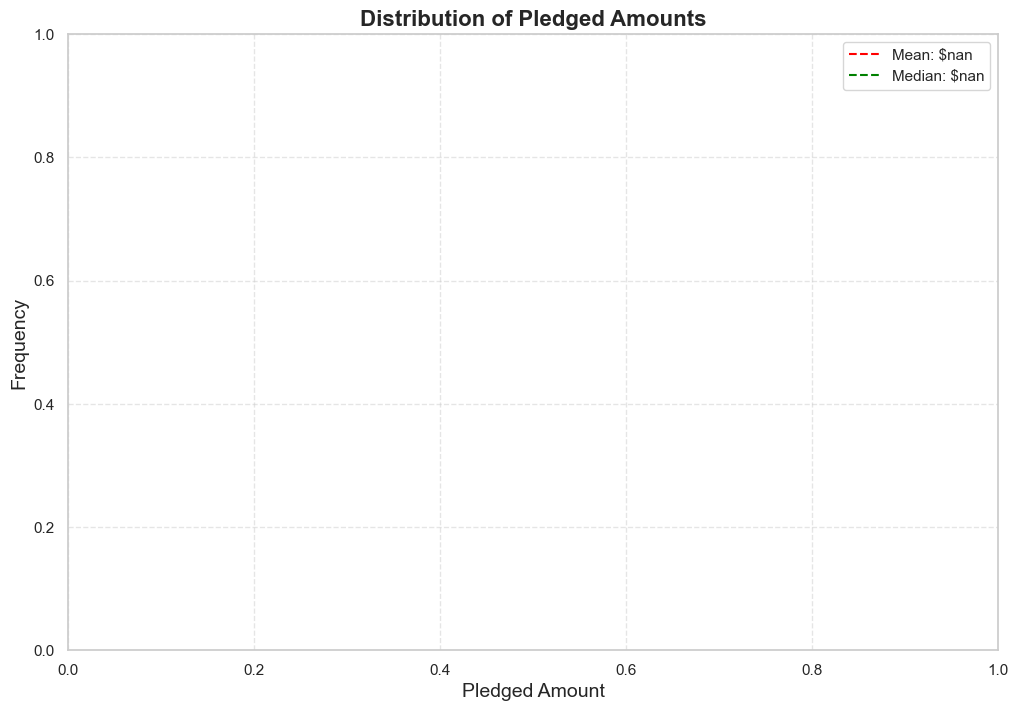

In [17]:
# Set the style and color palette of the visualization
sns.set(style="whitegrid", palette="pastel")

# Create the histogram
plt.figure(figsize=(12, 8))
hist_plot = sns.histplot(full_data_sql_df['pledged'], bins=30, kde=True, color='royalblue', alpha=0.7)

# Add title and labels with improved fonts
plt.title('Distribution of Pledged Amounts', fontsize=16, fontweight='bold')
plt.xlabel('Pledged Amount', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Add annotations to show the mean and median
mean_value = full_data_sql_df['pledged'].mean()
median_value = full_data_sql_df['pledged'].median()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: ${mean_value:,.0f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: ${median_value:,.0f}')

# Add a legend
plt.legend()

# Show the plot
plt.show()

#### Backer by country

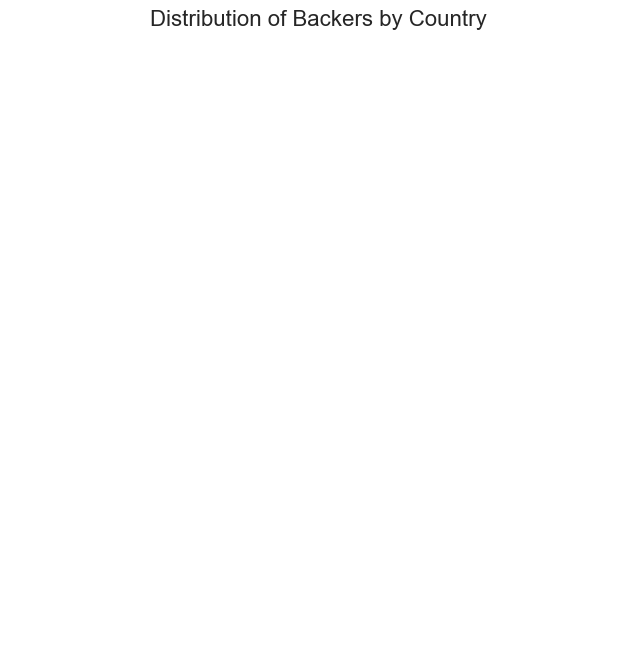

In [18]:
# Donut Chart: Distribution of backers across countries
backers_by_country_df = full_data_sql_df.groupby('country')['backers_count'].sum().reset_index()

# Define a color palette
colors = sns.color_palette('pastel')[0:len(backers_by_country_df)]

plt.figure(figsize=(8, 8))
plt.pie(backers_by_country_df['backers_count'], 
        labels=backers_by_country_df['country'], 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=colors,
        textprops={'fontsize': 14}, 
        wedgeprops=dict(width=0.4, edgecolor='w'))

# Draw a white circle at the center
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Title
plt.title('Distribution of Backers by Country', fontsize=16)
plt.show()

#### Pledged by category

In [19]:
# Violin plot of goal vs pledged amount
# Create the canvas
plt.figure(figsize=(14, 8))

# Create the violin plot
sns.violinplot(x='category', y='pledged', data=full_data_sql_df, inner='quartile', linewidth=1.5)

# Title and labels
plt.title('Pledged Amount by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Pledged', fontsize=14)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.ylim(-100000, 300000)

# Display grid lines
plt.grid(axis='y', color="gray", linestyle='--', alpha=0.7)

plt.show()

ValueError: min() arg is an empty sequence

<Figure size 1400x800 with 0 Axes>

#### Goal vs Pledged

In [ ]:
full_data_sql_df.info()

In [ ]:
# Scatter Plot: Relationship between goal and pledged amount
plt.figure(figsize=(12, 8))

# Enhanced scatter plot
sns.scatterplot(x='goal', y='pledged', data=full_data_sql_df, hue='country', palette='viridis', s=100, alpha=0.7, edgecolor='w', linewidth=0.5)

# Title and labels with improved font sizes
plt.title('Goal vs Pledged Amount', fontsize=18, weight='bold')
plt.xlabel('Goal Amount', fontsize=14)
plt.ylabel('Pledged Amount', fontsize=14)

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Legend customization
plt.legend(title='Country', title_fontsize='13', fontsize='11', loc='upper left', bbox_to_anchor=(1, 1))

# Background color
plt.gca().set_facecolor('#f0f0f0')

plt.show()

#### Top 10 Campaigns

In [ ]:
# Calculate percentage of goal reached
top_campaigns = 10

reached_goal_sql_df['percentage_reached'] = (reached_goal_sql_df['pledged'] / reached_goal_sql_df['goal']) * 100

# Sort and select top 10 campaigns
df_sorted = reached_goal_sql_df.sort_values(by='percentage_reached', ascending=False).head(top_campaigns)

# Progress Chart: Percentage of Goal Reached for top 10 Campaigns
plt.figure(figsize=(14, 8))
sns.barplot(x='company_name', y='percentage_reached', data=df_sorted, palette='viridis')
plt.axhline(y=100, color='r', linestyle='--', linewidth=2)
plt.title('Top Campaigns: Percentage of Goal Reached', fontsize=16)
plt.xlabel('Campaign', fontsize=14)
plt.ylabel('Percentage of Goal Reached', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

#### Linear regression of goals vs pledged

In [ ]:
# Set the style and color palette of the visualization
sns.set(style="whitegrid", palette="muted")

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(x='goal', y='pledged', data=full_data_sql_df, alpha=0.5, s=100, color='royalblue', edgecolor=None)

# Add a regression line for trend visualization
sns.regplot(x='goal', y='pledged', data=full_data_sql_df, scatter=False, color='black', line_kws={"linewidth":2, "linestyle":"solid"})

# Set the title and labels with improved fonts
plt.title('Scatter Plot of Goals vs. Pledged Amounts', fontsize=16, fontweight='bold')
plt.xlabel('Funding Goal', fontsize=14)
plt.ylabel('Pledged Amount', fontsize=14)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Add annotations for mean values
mean_goal = full_data_sql_df['goal'].mean()
mean_pledged = full_data_sql_df['pledged'].mean()
plt.axhline(mean_pledged, color='green', linestyle='dashed', linewidth=1.5, label=f'Mean Pledged: ${mean_pledged:,.0f}')
plt.axvline(mean_goal, color='firebrick', linestyle='solid', linewidth=1.5, label=f'Mean Goal: ${mean_goal:,.0f}')

# Add a legend
plt.legend()

# Show the plot
plt.show()
